In [188]:
import mechanicalsoup as ms
import requests
from zipfile import ZipFile
from tempfile import mktemp
import urllib
import os, csv, sys
import pandas as pd
from io import BytesIO
from urllib import request
from os.path import basename
from requests import get
from pathlib import Path
import numpy as np
from sklearn import preprocessing, cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from collections import OrderedDict
from multiprocessing import Process, Lock,Manager
from sklearn.metrics import classification_report
import operator

def downloadhistoricaldata(trainQ, testQ, t,s, flag):
    for l in t:
        if(trainQ in l['href'] or testQ in l['href']):
            c = 'https://freddiemac.embs.com/FLoan/Data/' + l['href']
            r = s.get(c)
            z = ZipFile(BytesIO(r.content)) 
            z.extractall(os.getcwd()+ '/data_part2')
            flag = 1
    return flag

def login(login, password, trainQ, testQ):
    flag = 0
    s = requests.Session()
    url = "https://freddiemac.embs.com/FLoan/secure/auth.php"
    url2 = "https://freddiemac.embs.com/FLoan/Data/download.php"
    browser = ms.Browser(session = s)
    print("Logging in....")
    login_page = browser.get(url)
    login_form = login_page.soup.find("form",{"class":"form"})
    login_form.find("input", {"name":"username"})["value"] = login
    login_form.find("input", {"name":"password"})["value"] = password
    response = browser.submit(login_form, login_page.url)
    login_page2 = browser.get(url2)
    print("To the continue page...")

    next_form = login_page2.soup.find("form",{"class":"fmform"})
    a= next_form.find("input",{"name": "accept"}).attrs
    a['checked']=True

    response2 = browser.submit(next_form, login_page2.url)
    print("Start Downloading from..."+ response2.url)
    table = response2.soup.find("table",{"class":"table1"})

    t = table.find_all('a')
    
    if 'data_part2' in os.getcwd():
        flag = downloadhistoricaldata(trainQ , testQ, t,s, flag)   
    else:
        print('Directory does not exists! Creating one..')
        os.mkdir('data_part2')
        flag = downloadhistoricaldata(trainQ, testQ, t,s, flag) 

    if flag == 1:
        print("Data downloaded successfully!!")
    else:
        print("Error in downloading data")
     

    
def load_df(quarter1,quarter2):  
    foldername= 'data_part2'
    historical_path= str(os.getcwd())+"\\"+ foldername
    train_path= historical_path+"\historical_data1_time_"+str(trainQ)+".txt"
    test_path= historical_path+"\historical_data1_time_"+str(testQ)+".txt"
    global train_df
    global test_df
    column_names=['loan_seq_number', 'month', 'current_actual_upb', 'delq_status','loan_age', 'rem_months', 'repurchase_flag', 'modification_flag', 'zero_balance_code',
                      'zero_bal_date', 'current_int_rate', 'current_def_upb', 'ddlpi', 'mi_recoveries', 'net_sales_proceeds',
                      'non_mi_recoveries', 'expenses', 'legal_costs', 'maint_pres_costs', 'taxes_ins', 'misc_expenses',
                      'actual_loss_calc', 'modification_cost']
    
    train_df = pd.read_table(os.path.join(train_path), 
                        delimiter='|', names=column_names, index_col=None, nrows=1048576, usecols=list(np.arange(23)))
    test_df = pd.read_table(os.path.join(test_path), 
                        delimiter='|', names=column_names, index_col=None, nrows=1048576, usecols=list(np.arange(23)))
    
   
    
def cleandf(df):
    df.delq_status = df.delq_status.replace('R', '1').astype('float64')
    df.rem_months = df.rem_months.replace(np.nan, 0)
    df.rem_months = df.rem_months.astype('category')
    df.repurchase_flag = df.repurchase_flag.replace(np.nan, 0)
    df.repurchase_flag = df.repurchase_flag.astype('category')
    df.modification_flag = df.modification_flag.replace(np.nan, 0)
    df.modification_flag = df.modification_flag.astype('category')
    df.zero_balance_code = df.zero_balance_code.replace(np.nan, 0)
    df.zero_balance_code = df.zero_balance_code.astype('category')
    df.zero_bal_date = df.zero_bal_date.replace(np.nan, 0)
    df.zero_bal_date = df.zero_bal_date.astype('category')
    df.current_def_upb = df.current_def_upb.replace(np.nan, 0)
    df.current_def_upb = df.current_def_upb.astype('category')
    df.ddlpi = df.ddlpi.replace(np.nan, 0)
    df.ddlpi = df.ddlpi.astype('category')
    df.mi_recoveries = df.mi_recoveries.replace(np.nan, 0)
    df.net_sales_proceeds = df.net_sales_proceeds.replace(np.nan, 0)
    df.net_sales_proceeds = df.net_sales_proceeds.replace('C', 1)
    df.net_sales_proceeds = df.net_sales_proceeds.replace('U', 0)
    df.net_sales_proceeds.astype('float64')
    df.non_mi_recoveries = df.non_mi_recoveries.replace(np.nan, 0)
    df.expenses = df.expenses.replace(np.nan, 0)
    df.legal_costs = df.legal_costs.replace(np.nan, 0)
    df.maint_pres_costs = df.maint_pres_costs.replace(np.nan, 0)
    df.taxes_ins = df.taxes_ins.replace(np.nan, 0)
    df.misc_expenses = df.misc_expenses.replace(np.nan, 0)
    df.actual_loss_calc = df.actual_loss_calc.replace(np.nan, 0)
    df.modification_cost = df.modification_cost.replace(np.nan, 0)
    
def get_train_test_set():

    def f(row):
        if row['delq_status'] > 0:
            val = 1
        else:
            val = 0
        return val
    
    #Create dummy variables
    train_df_dummies = pd.get_dummies(train_df[['repurchase_flag', 'modification_flag']])
    test_df_dummies = pd.get_dummies(test_df[['repurchase_flag', 'modification_flag']])

    dropped_train_df = train_df.drop(['loan_seq_number','repurchase_flag', 'modification_flag'],axis=1)
    dropped_test_df = test_df.drop(['loan_seq_number','repurchase_flag', 'modification_flag'],axis=1)

    global final_train_df
    global final_test_df
    final_train_df = pd.concat([dropped_train_df, train_df_dummies], axis=1)
    final_test_df = pd.concat([dropped_test_df, test_df_dummies], axis=1)
    
    #create target variable 
    final_train_df['Deliquent'] = final_train_df.apply(f, axis=1)
    final_test_df['Deliquent'] = final_test_df.apply(f, axis=1)
    
    #create testing and training set
    X_train = final_train_df.drop(['delq_status', 'Deliquent'], axis=1)
    y_train = final_train_df['Deliquent']

    X_test = final_test_df.drop(['delq_status', 'Deliquent'], axis=1)
    y_test = final_test_df['Deliquent']
    
    #preprocess to scale it between 0 and 1
    X_train = preprocessing.minmax_scale(X_train)
    X_test = preprocessing.minmax_scale(X_test)
    
    return X_train,y_train,X_test,y_test

def logisticRegression(X_train, y_train,X_test,y_test,logire_return_dict):
    logisticReg = LogisticRegression()
    
    #fit the data
    logisticReg.fit(X_train, y_train)
    
    #prediction data
    y_train_predicted = logisticReg.predict(X_train)
    y_test_predicted = logisticReg.predict(X_test)
    conf_mat_logire = metrics.confusion_matrix(y_test, y_test_predicted)
    print("Confusion matrix for " + trainQ + " is: " + str(conf_mat_logire))
    
    #ROC and AUC
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_test_predicted)
    roc_auc_logire = metrics.auc(false_positive_rate, true_positive_rate)
    logire_return_dict['roc_auc_logire']=roc_auc_logire
    logire_return_dict['conf_mat_logire']=conf_mat_logire
    roc_auc_logire = round(roc_auc_logire,2)
    print("ROC curve for " + trainQ + " is: " + str(roc_auc_logire))
    
    #plot Curve
    plt.title("Logistic Regression")
    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = ' + str(roc_auc_logire))
    plt.legend(loc='upper right')
    plt.plot([0,1],[0,1],'g--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def random_forest(X_train, y_train,X_test,y_test,randf_return_dict):
    ranf = RandomForestClassifier(n_estimators=100)
    
    #fit the data
    ranf.fit(X_train, y_train)

    #prediction data
    y_train_predicted = ranf.predict(X_train)
    y_test_predicted = ranf.predict(X_test)
        
    #confustion matrix
    ranf_conf_mat = metrics.confusion_matrix(y_test, y_test_predicted)
    print("Confusion matrix for " + trainQ + " is: " + str(ranf_conf_mat))

    #ROC and AUC curve
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_test_predicted)
    ranf_roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    ranf_roc_auc = round(ranf_roc_auc, 2)
    print("ROC curve for " + trainQ + " is: " + str(ranf_roc_auc))
    randf_return_dict['ranf_roc_auc']=ranf_roc_auc
    randf_return_dict['ranf_conf_mat']=ranf_conf_mat
    
    #plot curve
    plt.title("Random Forest")
    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = ' + str(ranf_roc_auc))
    plt.legend(loc='upper right')
    plt.plot([0,1],[0,1],'g--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def neural_network(X_train, y_train,X_test,y_test,neun_return_dict):
    neun = MLPClassifier()

    #fit the data
    neun.fit(X_train, y_train)

    #prediction data
    y_train_predicted = neun.predict(X_train)
    y_test_predicted = neun.predict(X_test)
    
    #confusion matrix
    neun_conf_mat = metrics.confusion_matrix(y_test, y_test_predicted)
    print("Confusion matrix for " + trainQ + " is: " + str(neun_conf_mat))

    #ROC and AUC
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_test_predicted)
    neun_roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    neun_roc_auc = round(neun_roc_auc,2)
    print("ROC curve for " + trainQ + " is: " + str(neun_roc_auc))
    neun_return_dict['neun_roc_auc']=neun_roc_auc
    neun_return_dict['neun_conf_mat']=neun_conf_mat
    
    #plot curve
    plt.title("Neural Network")
    plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = ' + str(neun_roc_auc ))
    plt.legend(loc='upper right')
    plt.plot([0,1],[0,1],'g--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def get_next_quarter(QUARTER):
        quarterNumber = int(QUARTER[1])
        quarterYear= int(QUARTER[2:6])
        
        if quarterNumber < 4:
            newQuarterNumber = quarterNumber + 1
            newQuarterYear = quarterYear
        else:
            newQuarterNumber = quarterNumber - 3
            newQuarterYear = quarterYear + 1
            
        QUARTER2 = "Q" + str(newQuarterNumber) + str(newQuarterYear)
            
        return QUARTER2

def get_matrix(quarter,roc_auc_logire,ranf_roc_auc,neun_roc_auc,conf_mat_logire,ranf_conf_mat,neun_conf_mat,matrix):
    all_auc={'logisticRegression':roc_auc_logire,'random_forest':ranf_roc_auc,'neural_network':neun_roc_auc}
    print(all_auc)
    model=max(all_auc.items(),key=operator.itemgetter(1))[0]
    all_conf={'logisticRegression':conf_mat_logire,'random_forest':ranf_conf_mat,'neural_network':neun_conf_mat}
    all_conf_array = all_conf[model]
    No_of_actual_delq = all_conf_array[1][0] + all_conf_array[1][1]
    No_of_pred_delq = all_conf_array[0][1] + all_conf_array[1][1]
    No_of_records = all_conf_array[0][1] + all_conf_array[1][1] + all_conf_array[1][0] + all_conf_array[0][0]
    No_of_delq_properly_classified = all_conf_array[1][1]
    No_of_nonDelq_improperly_classified_as_delq = all_conf_array[0][1]
    all_conf_df = pd.DataFrame(OrderedDict((('Quarter',[quarter]), 
                                 ('Number_of_Actual_Delinquents',[No_of_actual_delq]),
                                 ('Number_of_Predicted_Delinquents',[No_of_pred_delq]),
                                 ('Number_of_records_in_the_dataset ',[No_of_records]),
                                 ('Number_of_Delinquents_properly_classified',[No_of_delq_properly_classified]),
                                 ('Number_of_non_delinquents_improperly_classified_as_delinquents',[No_of_nonDelq_improperly_classified_as_delq]))))
    
    matrix=pd.concat([all_conf_df, matrix],axis=0)
    return matrix

if __name__ == '__main__':
global X_train 
global y_train
global X_test
global y_test
global matrix
global conf_mat_logire
global ranf_conf_mat
global neun_conf_mat
global roc_auc_logire
global ranf_roc_auc
global neun_roc_auc
manager=Manager()
logire_return_dict=manager.dict()
randf_return_dict=manager.dict()
neun_return_dict=manager.dict()
matrix = pd.DataFrame(OrderedDict((('Quarter',[]), 
                                 ('Number_of_Actual_Delinquents',[]),
                                 ('Number_of_Predicted_Delinquents',[]),
                                 ('Number_of_records_in_the_dataset',[]),
                                 ('Number_of_Delinquents_properly_classified',[]),
                                 ('Number_of_non_delinquents_improperly_classified_as_delinquents',[]))))

quarters=[]
quarters.append(trainQ)

for q in quarters:
    nextQuarter=get_next_quarter(q)
    load_df(q,nextQuarter)
    cleandf(train_df)
    cleandf(test_df)
    X_train,y_train,X_test,y_test=get_train_test_set()
    print("Traing and Testing set are ready to build models.")

    p1 = Process(target=logisticRegression,args=(X_train, y_train,X_test,y_test,logire_return_dict))
    p2 = Process(target=random_forest,args=(X_train, y_train,X_test,y_test,randf_return_dict))
    p3 = Process(target=neural_network,args=(X_train, y_train,X_test,y_test,neun_return_dict))
    p1.start()
    p2.start()
    p3.start()
    p1.join()
    p2.join()
    p3.join()
    logisticRegression(X_train, y_train,X_test,y_test,logire_return_dict)
    random_forest(X_train, y_train,X_test,y_test,randf_return_dict)
    neural_network(X_train, y_train,X_test,y_test,neun_return_dict)
    matrix=get_matrix(q,logire_return_dict['roc_auc_logire'],randf_return_dict['ranf_roc_auc'],neun_return_dict['neun_roc_auc'],logire_return_dict['conf_mat_logire'],randf_return_dict['ranf_conf_mat'],neun_return_dict['neun_conf_mat'],matrix)        

print(matrix) 
filename = os.getcwd() + '\matrix_classification.csv'
matrix.to_csv(filename,index= False, encoding='utf-8')

Logging in....
To the continue page...
Start Downloading from...https://freddiemac.embs.com/FLoan/Data/download.php
Directory does not exists! Creating one..


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data_part2'

In [310]:
def load_df(quarter1,quarter2):  
    foldername= 'data_part2'
    historical_path= str(os.getcwd())+"\\"+ foldername
    train_path= historical_path+"\historical_data1_time_"+str(trainQ)+".txt"
    test_path= historical_path+"\historical_data1_time_"+str(testQ)+".txt"
    global train_df
    global test_df
    column_names=['loan_seq_number', 'month', 'current_actual_upb', 'delq_status','loan_age', 'rem_months', 'repurchase_flag', 'modification_flag', 'zero_balance_code',
                      'zero_bal_date', 'current_int_rate', 'current_def_upb', 'ddlpi', 'mi_recoveries', 'net_sales_proceeds',
                      'non_mi_recoveries', 'expenses', 'legal_costs', 'maint_pres_costs', 'taxes_ins', 'misc_expenses',
                      'actual_loss_calc', 'modification_cost']
    
    train_df = pd.read_table(os.path.join(train_path), 
                        delimiter='|', names=column_names, index_col=None, nrows=1048576, usecols=list(np.arange(23)))
    test_df = pd.read_table(os.path.join(test_path), 
                        delimiter='|', names=column_names, index_col=None, nrows=1048576, usecols=list(np.arange(23)))
    


In [311]:
#load_df(trainQ, testQ)

C:\Users\smits_000\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2827: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [312]:
#train_df.shape

(1048576, 23)

In [313]:
#test_df.shape

(1048576, 23)

In [314]:
#train_df.head(3)

,loan_seq_number,month,current_actual_upb,delq_status,loan_age,rem_months,repurchase_flag,modification_flag,zero_balance_code,zero_bal_date,...,mi_recoveries,net_sales_proceeds,non_mi_recoveries,expenses,legal_costs,maint_pres_costs,taxes_ins,misc_expenses,actual_loss_calc,modification_cost
1048573,F105Q4014681,200701,165576.93,0,14,346,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048574,F105Q4014681,200702,165181.15,0,15,345,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048575,F105Q4014681,200703,164783.52,0,16,344,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [316]:
#test_df.head(3)

,loan_seq_number,month,current_actual_upb,delq_status,loan_age,rem_months,repurchase_flag,modification_flag,zero_balance_code,zero_bal_date,...,mi_recoveries,net_sales_proceeds,non_mi_recoveries,expenses,legal_costs,maint_pres_costs,taxes_ins,misc_expenses,actual_loss_calc,modification_cost
0,F106Q1000001,200603,130000.0,0,0,360,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,F106Q1000001,200604,130000.0,0,1,359,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,F106Q1000001,200605,130000.0,0,2,358,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [317]:
def cleandf(df):
    df.delq_status = df.delq_status.replace('R', '1').astype('float64')
    df.rem_months = df.rem_months.replace(np.nan, 0)
    df.rem_months = df.rem_months.astype('category')
    df.repurchase_flag = df.repurchase_flag.replace(np.nan, 0)
    df.repurchase_flag = df.repurchase_flag.astype('category')
    df.modification_flag = df.modification_flag.replace(np.nan, 0)
    df.modification_flag = df.modification_flag.astype('category')
    df.zero_balance_code = df.zero_balance_code.replace(np.nan, 0)
    df.zero_balance_code = df.zero_balance_code.astype('category')
    df.zero_bal_date = df.zero_bal_date.replace(np.nan, 0)
    df.zero_bal_date = df.zero_bal_date.astype('category')
    df.current_def_upb = df.current_def_upb.replace(np.nan, 0)
    df.current_def_upb = df.current_def_upb.astype('category')
    df.ddlpi = df.ddlpi.replace(np.nan, 0)
    df.ddlpi = df.ddlpi.astype('category')
    df.mi_recoveries = df.mi_recoveries.replace(np.nan, 0)
    df.net_sales_proceeds = df.net_sales_proceeds.replace(np.nan, 0)
    df.net_sales_proceeds = df.net_sales_proceeds.replace('C', 1)
    df.net_sales_proceeds = df.net_sales_proceeds.replace('U', 0)
    df.net_sales_proceeds.astype('float64')
    df.non_mi_recoveries = df.non_mi_recoveries.replace(np.nan, 0)
    df.expenses = df.expenses.replace(np.nan, 0)
    df.legal_costs = df.legal_costs.replace(np.nan, 0)
    df.maint_pres_costs = df.maint_pres_costs.replace(np.nan, 0)
    df.taxes_ins = df.taxes_ins.replace(np.nan, 0)
    df.misc_expenses = df.misc_expenses.replace(np.nan, 0)
    df.actual_loss_calc = df.actual_loss_calc.replace(np.nan, 0)
    df.modification_cost = df.modification_cost.replace(np.nan, 0)

In [318]:
#cleandf(train_df)

In [319]:
#train_df.head(3)

,loan_seq_number,month,current_actual_upb,delq_status,loan_age,rem_months,repurchase_flag,modification_flag,zero_balance_code,zero_bal_date,...,mi_recoveries,net_sales_proceeds,non_mi_recoveries,expenses,legal_costs,maint_pres_costs,taxes_ins,misc_expenses,actual_loss_calc,modification_cost
0,F105Q4000001,200512,77000.0,0.0,0,360,0,0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,F105Q4000001,200601,76000.0,0.0,1,359,0,0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,F105Q4000001,200602,76000.0,0.0,2,358,0,0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [320]:
#cleandf(test_df)

In [321]:
test_df.head(3)

,loan_seq_number,month,current_actual_upb,delq_status,loan_age,rem_months,repurchase_flag,modification_flag,zero_balance_code,zero_bal_date,...,mi_recoveries,net_sales_proceeds,non_mi_recoveries,expenses,legal_costs,maint_pres_costs,taxes_ins,misc_expenses,actual_loss_calc,modification_cost
0,F106Q1000001,200603,130000.0,0.0,0,360,0,0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,F106Q1000001,200604,130000.0,0.0,1,359,0,0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,F106Q1000001,200605,130000.0,0.0,2,358,0,0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [322]:
def get_train_test_set():

    def f(row):
        if row['delq_status'] > 0:
            val = 1
        else:
            val = 0
        return val
    
    #Create dummy variables
    train_df_dummies = pd.get_dummies(train_df[['repurchase_flag', 'modification_flag']])
    test_df_dummies = pd.get_dummies(test_df[['repurchase_flag', 'modification_flag']])

    dropped_train_df = train_df.drop(['loan_seq_number','repurchase_flag', 'modification_flag'],axis=1)
    dropped_test_df = test_df.drop(['loan_seq_number','repurchase_flag', 'modification_flag'],axis=1)

    global final_train_df
    global final_test_df
    final_train_df = pd.concat([dropped_train_df, train_df_dummies], axis=1)
    final_test_df = pd.concat([dropped_test_df, test_df_dummies], axis=1)
    
    #create target variable 
    final_train_df['Deliquent'] = final_train_df.apply(f, axis=1)
    final_test_df['Deliquent'] = final_test_df.apply(f, axis=1)
    
    #create testing and training set
    X_train = final_train_df.drop(['delq_status', 'Deliquent'], axis=1)
    y_train = final_train_df['Deliquent']

    X_test = final_test_df.drop(['delq_status', 'Deliquent'], axis=1)
    y_test = final_test_df['Deliquent']
    
    #preprocess to scale it between 0 and 1
    X_train = preprocessing.minmax_scale(X_train)
    X_test = preprocessing.minmax_scale(X_test)
    
    return X_train,y_train,X_test,y_test

In [323]:
def logisticRegression(X_train, y_train,X_test,y_test,logire_return_dict):
    logisticReg = LogisticRegression()
    
    #fit the data
    logisticReg.fit(X_train, y_train)
    
    #prediction data
    y_train_predicted = logisticReg.predict(X_train)
    y_test_predicted = logisticReg.predict(X_test)
    conf_mat_logire = metrics.confusion_matrix(y_test, y_test_predicted)
    print("Confusion matrix for " + trainQ + " is: " + str(conf_mat_logire))
    
    #ROC and AUC
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_test_predicted)
    roc_auc_logire = metrics.auc(false_positive_rate, true_positive_rate)
    logire_return_dict['roc_auc_logire']=roc_auc_logire
    logire_return_dict['conf_mat_logire']=conf_mat_logire
    roc_auc_logire = round(roc_auc_logire,2)
    print("ROC curve for " + trainQ + " is: " + str(roc_auc_logire))
    
    #plot Curve
    plt.title("Logistic Regression")
    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = ' + str(roc_auc_logire))
    plt.legend(loc='upper right')
    plt.plot([0,1],[0,1],'g--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


Confusion matrix for Q12005 is: [[997305   1496]
 [ 47412   2363]]
ROC curve for Q12005 is: 0.52


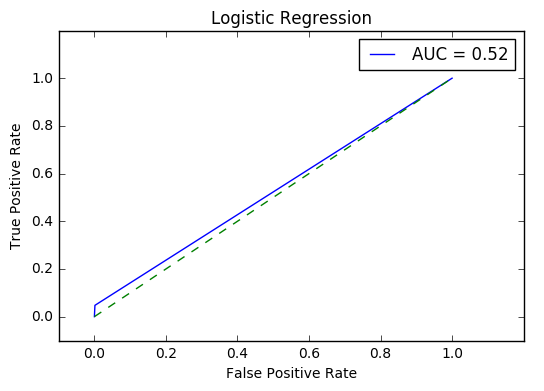

In [212]:
manager=Manager()
logire_return_dict=manager.dict()
logisticRegression(X_train, y_train,X_test,y_test,logire_return_dict)


In [324]:
def random_forest(X_train, y_train,X_test,y_test,randf_return_dict):
    ranf = RandomForestClassifier(n_estimators=100)
    
    #fit the data
    ranf.fit(X_train, y_train)

    #prediction data
    y_train_predicted = ranf.predict(X_train)
    y_test_predicted = ranf.predict(X_test)
        
    #confustion matrix
    ranf_conf_mat = metrics.confusion_matrix(y_test, y_test_predicted)
    print("Confusion matrix for " + trainQ + " is: " + str(ranf_conf_mat))

    #ROC and AUC curve
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_test_predicted)
    ranf_roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    ranf_roc_auc = round(ranf_roc_auc, 2)
    print("ROC curve for " + trainQ + " is: " + str(ranf_roc_auc))
    randf_return_dict['ranf_roc_auc']=ranf_roc_auc
    randf_return_dict['ranf_conf_mat']=ranf_conf_mat
    
    #plot curve
    plt.title("Random Forest")
    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = ' + str(ranf_roc_auc))
    plt.legend(loc='upper right')
    plt.plot([0,1],[0,1],'g--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Confusion matrix for Q12005 is: [[981978  16823]
 [ 45397   4378]]
ROC curve for Q12005 is: 0.54


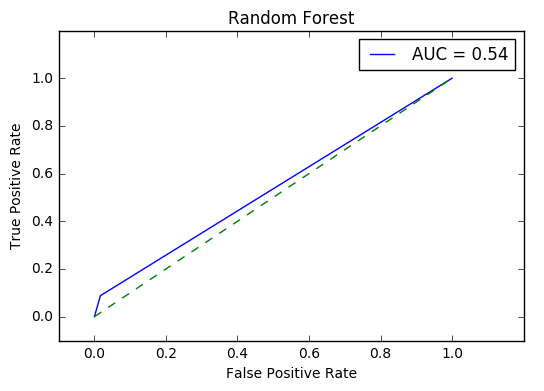

In [216]:
manager=Manager()
randf_return_dict=manager.dict()
random_forest(X_train, y_train,X_test,y_test,randf_return_dict)

In [325]:
def neural_network(X_train, y_train,X_test,y_test,neun_return_dict):
    neun = MLPClassifier()

    #fit the data
    neun.fit(X_train, y_train)

    #prediction data
    y_train_predicted = neun.predict(X_train)
    y_test_predicted = neun.predict(X_test)
    
    #confusion matrix
    neun_conf_mat = metrics.confusion_matrix(y_test, y_test_predicted)
    print("Confusion matrix for " + trainQ + " is: " + str(neun_conf_mat))

    #ROC and AUC
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_test_predicted)
    neun_roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    neun_roc_auc = round(neun_roc_auc,2)
    print("ROC curve for " + trainQ + " is: " + str(neun_roc_auc))
    neun_return_dict['neun_roc_auc']=neun_roc_auc
    neun_return_dict['neun_conf_mat']=neun_conf_mat
    
    #plot curve
    plt.title("Neural Network")
    plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = ' + str(neun_roc_auc ))
    plt.legend(loc='upper right')
    plt.plot([0,1],[0,1],'g--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Confusion matrix for Q12005 is: [[998771     30]
 [ 48126   1649]]
ROC curve for Q12005 is: 0.52


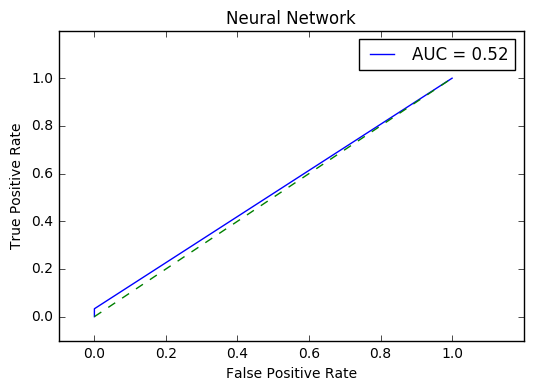

In [180]:
manager=Manager()
neun_return_dict=manager.dict()
neural_network(X_train, y_train,X_test,y_test,neun_return_dict)

In [326]:
def get_matrix(quarter,roc_auc_logire,ranf_roc_auc,neun_roc_auc,conf_mat_logire,ranf_conf_mat,neun_conf_mat,matrix):
    all_auc={'logisticRegression':roc_auc_logire,'random_forest':ranf_roc_auc,'neural_network':neun_roc_auc}
    print(all_auc)
    model=max(all_auc.items(),key=operator.itemgetter(1))[0]
    all_conf={'logisticRegression':conf_mat_logire,'random_forest':ranf_conf_mat,'neural_network':neun_conf_mat}
    all_conf_array = all_conf[model]
    No_of_actual_delq = all_conf_array[1][0] + all_conf_array[1][1]
    No_of_pred_delq = all_conf_array[0][1] + all_conf_array[1][1]
    No_of_records = all_conf_array[0][1] + all_conf_array[1][1] + all_conf_array[1][0] + all_conf_array[0][0]
    No_of_delq_properly_classified = all_conf_array[1][1]
    No_of_nonDelq_improperly_classified_as_delq = all_conf_array[0][1]
    all_conf_df = pd.DataFrame(OrderedDict((('Quarter',[quarter]), 
                                 ('Number_of_Actual_Delinquents',[No_of_actual_delq]),
                                 ('Number_of_Predicted_Delinquents',[No_of_pred_delq]),
                                 ('Number_of_records_in_the_dataset ',[No_of_records]),
                                 ('Number_of_Delinquents_properly_classified',[No_of_delq_properly_classified]),
                                 ('Number_of_non_delinquents_improperly_classified_as_delinquents',[No_of_nonDelq_improperly_classified_as_delq]))))
    
    matrix=pd.concat([all_conf_df, matrix],axis=0)
    return matrix

C:\Users\smits_000\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Traing and Testing set are ready to build models.
Confusion matrix for Q42005 is: [[ 14915 956947]
 [  1244  75470]]
ROC curve for Q42005 is: 0.5


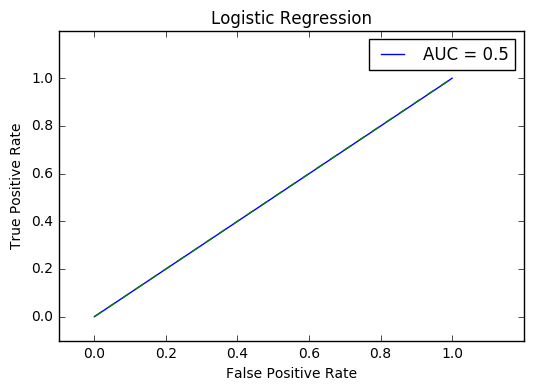

Confusion matrix for Q42005 is: [[695178 276684]
 [ 37080  39634]]
ROC curve for Q42005 is: 0.62


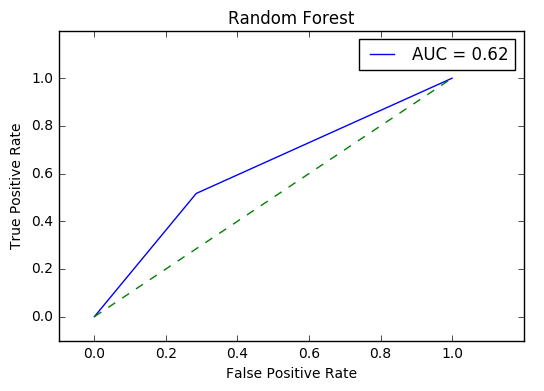

Confusion matrix for Q42005 is: [[  9096 962766]
 [  1684  75030]]
ROC curve for Q42005 is: 0.49


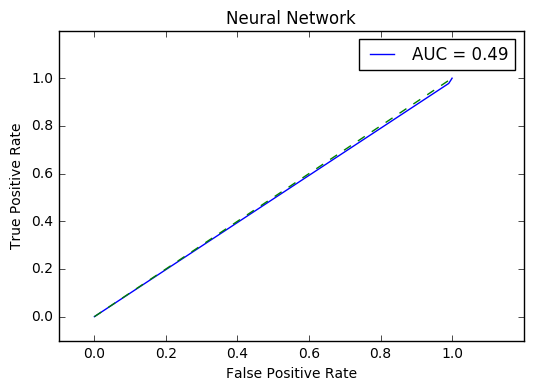

{'random_forest': 0.62, 'neural_network': 0.48999999999999999, 'logisticRegression': 0.49956537689195535}
   Number_of_Actual_Delinquents  Number_of_Delinquents_properly_classified  \
0                       76714.0                                    39634.0   

   Number_of_Predicted_Delinquents  \
0                         316318.0   

   Number_of_non_delinquents_improperly_classified_as_delinquents  \
0                                           276684.0                

   Number_of_records_in_the_dataset  Number_of_records_in_the_dataset  Quarter  
0                               NaN                          1048576.0  Q42005  


In [327]:
global X_train 
global y_train
global X_test
global y_test
global matrix
global conf_mat_logire
global ranf_conf_mat
global neun_conf_mat
global roc_auc_logire
global ranf_roc_auc
global neun_roc_auc
manager=Manager()
logire_return_dict=manager.dict()
randf_return_dict=manager.dict()
neun_return_dict=manager.dict()
matrix = pd.DataFrame(OrderedDict((('Quarter',[]), 
                                 ('Number_of_Actual_Delinquents',[]),
                                 ('Number_of_Predicted_Delinquents',[]),
                                 ('Number_of_records_in_the_dataset',[]),
                                 ('Number_of_Delinquents_properly_classified',[]),
                                 ('Number_of_non_delinquents_improperly_classified_as_delinquents',[]))))
    
#Get user input to download quaterly historical data   
quarter_input=str(os.getcwd())+"\\"+'quarter_input.csv'  
reader=csv.reader(open(quarter_input),delimiter=',')
quarter_data=[]
for row in reader:
    quarter_data.append(row)  
    trainQ= quarter_data[0][0]
    testQ = quarter_data[0][1]
    username = quarter_data[0][2]
    password = quarter_data[0][3]
    
quarters=[]
quarters.append(trainQ)

for q in quarters:
    nextQuarter=get_next_quarter(q)
    #download the data
    login(username, password, trainQ, testQ)
    load_df(q,nextQuarter)
    cleandf(train_df)
    cleandf(test_df)
    X_train,y_train,X_test,y_test=get_train_test_set()
    print("Traing and Testing set are ready to build models.")

    p1 = Process(target=logisticRegression,args=(X_train, y_train,X_test,y_test,logire_return_dict))
    p2 = Process(target=random_forest,args=(X_train, y_train,X_test,y_test,randf_return_dict))
    p3 = Process(target=neural_network,args=(X_train, y_train,X_test,y_test,neun_return_dict))
    p1.start()
    p2.start()
    p3.start()
    p1.join()
    p2.join()
    p3.join()
    logisticRegression(X_train, y_train,X_test,y_test,logire_return_dict)
    random_forest(X_train, y_train,X_test,y_test,randf_return_dict)
    neural_network(X_train, y_train,X_test,y_test,neun_return_dict)
    matrix=get_matrix(q,logire_return_dict['roc_auc_logire'],randf_return_dict['ranf_roc_auc'],neun_return_dict['neun_roc_auc'],logire_return_dict['conf_mat_logire'],randf_return_dict['ranf_conf_mat'],neun_return_dict['neun_conf_mat'],matrix)        

print(matrix)

In [328]:
filename = os.getcwd() + '\matrix_classification.csv'
matrix.to_csv(filename,index= False, encoding='utf-8')

In [329]:
def get_next_quarter(QUARTER):
        quarterNumber = int(QUARTER[1])
        quarterYear= int(QUARTER[2:6])
        
        if quarterNumber < 4:
            newQuarterNumber = quarterNumber + 1
            newQuarterYear = quarterYear
        else:
            newQuarterNumber = quarterNumber - 3
            newQuarterYear = quarterYear + 1
            
        QUARTER2 = "Q" + str(newQuarterNumber) + str(newQuarterYear)
            
        return QUARTER2

In [ ]:
if __name__ == '__main__':
global X_train 
global y_train
global X_test
global y_test
global matrix
global conf_mat_logire
global ranf_conf_mat
global neun_conf_mat
global roc_auc_logire
global ranf_roc_auc
global neun_roc_auc
manager=Manager()
logire_return_dict=manager.dict()
randf_return_dict=manager.dict()
neun_return_dict=manager.dict()
matrix = pd.DataFrame(OrderedDict((('Quarter',[]), 
                                 ('Number_of_Actual_Delinquents',[]),
                                 ('Number_of_Predicted_Delinquents',[]),
                                 ('Number_of_records_in_the_dataset',[]),
                                 ('Number_of_Delinquents_properly_classified',[]),
                                 ('Number_of_non_delinquents_improperly_classified_as_delinquents',[]))))

quarters=[]
quarters.append(trainQ)

for q in quarters:
    nextQuarter=get_next_quarter(q)
    load_df(q,nextQuarter)
    cleandf(train_df)
    cleandf(test_df)
    X_train,y_train,X_test,y_test=get_train_test_set()
    print("Traing and Testing set are ready to build models.")

    p1 = Process(target=logisticRegression,args=(X_train, y_train,X_test,y_test,logire_return_dict))
    p2 = Process(target=random_forest,args=(X_train, y_train,X_test,y_test,randf_return_dict))
    p3 = Process(target=neural_network,args=(X_train, y_train,X_test,y_test,neun_return_dict))
    p1.start()
    p2.start()
    p3.start()
    p1.join()
    p2.join()
    p3.join()
    logisticRegression(X_train, y_train,X_test,y_test,logire_return_dict)
    random_forest(X_train, y_train,X_test,y_test,randf_return_dict)
    neural_network(X_train, y_train,X_test,y_test,neun_return_dict)
    matrix=get_matrix(q,logire_return_dict['roc_auc_logire'],randf_return_dict['ranf_roc_auc'],neun_return_dict['neun_roc_auc'],logire_return_dict['conf_mat_logire'],randf_return_dict['ranf_conf_mat'],neun_return_dict['neun_conf_mat'],matrix)        

print(matrix) 
filename = os.getcwd() + '\matrix_classification.csv'
matrix.to_csv(filename,index= False, encoding='utf-8')